### PNL Analisis de Sentimientos 

In [86]:
#!pip install wordcloud

In [87]:
#nltk.download('vader_lexicon')

In [88]:
#nltk.download('stopwords')
#nltk.download('punkt')

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk, re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [90]:
#visualizar texto completo del tweet y su sentimiento
pd.set_option('display.max_colwidth', None)

Vamos a realizar analisis de sentimientos con una libreria llamada nltk con un modelo llamado SentimentIntensityAnalyzer para despues compararlo con el modelo BETO (Bidirectional Encoder Representations from Transformers for Spanish) de la biblioteca transformers. 

Para posteriormente entrenar un modelo propio y probarlo

#### Proceso a seguir para analisis

In [91]:
df = pd.read_csv('tweets.csv')
df = df.drop(['usuario',], axis=1)
df.head(3)

,tweet
0,"Joaquín López-Dóriga\n@lopezdoriga\n·\n10 jun.\nEl que no se iba a meter en el proceso interno de Morena dijo que cualquiera de las 'corcholatas' es garantía de continuidad de la 4T.\n\nhttps://bit.ly/43s8bJY\n149\n83\n300\n36,4 mil"
1,"Animal Político\n@Pajaropolitico\n·\n10 jun.\n#OJO | Páginas en Facebook que promocionan a las ‘corcholatas’ de Morena de cara a las elecciones de 2024 acumulan desde 2022 un gasto de al menos 5 millones de pesos en anuncios para amplificar su contenido.\nanimalpolitico.com\nElección 2024: Gastan 5 mdp en promoción de 'corcholatas'\nPáginas en Facebook promocionan a las ‘corcholatas’ de Morena de cara a las elecciones de 2024. Acumulan un gasto de 5 millones de pesos.\n7\n186\n266\n19,7 mil"
2,"Pascal\n@beltrandelrio\n·\n42min\nEstá previsto que entre las reglas que al rato “definirá” el Consejo Nacional de Morena (entrecomillo el verbo porque la definición ya la hizo YSQ), estará que el 2o y 3er lugar de la encuesta entre corcholatas serán los coordinadores de la bancada de senadores y diputados (1/3)\n16\n106\n342\n25,7 mil\nMostrar este hilo"


In [92]:
df.isnull().sum()

tweet    0
dtype: int64

In [93]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Función de preprocesamiento de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Remover números
    text = re.sub(r'\d+', '', text)
    
    # Remover signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Remover palabras vacías (stop words)
    stop_words = set(stopwords.words('spanish'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Unir tokens en un solo texto
    preprocessed_text = ' '.join(tokens)

    #remover urls y reemplazar por la palabra URL
    preprocessed_text = re.sub(r'https?:\/\/\S+', 'URL', preprocessed_text)

    #eliminar la palabra jun debido a que fueron recuentos de junio
    preprocessed_text = re.sub(r'jun', '', preprocessed_text)
    
    return preprocessed_text



In [94]:
# Aplicar preprocesamiento a la columna 'texto'
df['tweet'] = df['tweet'].apply(preprocess_text)

# Imprimir el DataFrame con el texto preprocesado
df.head(3)

,tweet
0,joaquín lópezdóriga lopezdoriga · iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil
1,animal político pajaropolitico · ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo


Ahora que nuestros tweets están impecables, es hora de usarlos para tener una idea de los sentimientos de las personas mediante el uso para calcular la puntuación de polaridad de cada tweet. Esto nos ayudará a averiguar si los tweets son en su mayoría positivos, negativos o neutrales y nos dará una idea de lo que la gente está diciendo sobre el tema.SentimentIntensityAnalyzer

In [95]:
for index, row in df['tweet'].iteritems():
  score = SentimentIntensityAnalyzer().polarity_scores(row)
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  if neg > pos:
    df.loc[index, 'Sentiment[NLTK]'] = 'Negative'
  elif pos > neg:
    df.loc[index, 'Sentiment[NLTK]'] = 'Positive'
  else:
    df.loc[index, 'Sentiment[NLTK]'] = 'Neutral'

df.head(3)

C:\Users\Adolfo\AppData\Local\Temp\ipykernel_10300\2399571646.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in df['tweet'].iteritems():


,tweet,Sentiment[NLTK]
0,joaquín lópezdóriga lopezdoriga · iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutral
1,animal político pajaropolitico · ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutral
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutral


Imprimimos los primeros resultados

In [96]:
def count_tp_in_column(data,feature):
  total = data.loc[:,feature].value_counts(dropna=False)
  percentage = data.loc[:,feature].value_counts(dropna=False, normalize=True)*100
  return pd.concat([total, round(percentage,2)], axis=1, keys=['Total', 'Percentage'])

tp = count_tp_in_column(df,'Sentiment[NLTK]')
tp

,Total,Percentage
Neutral,86,88.66
Positive,8,8.25
Negative,3,3.09


<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

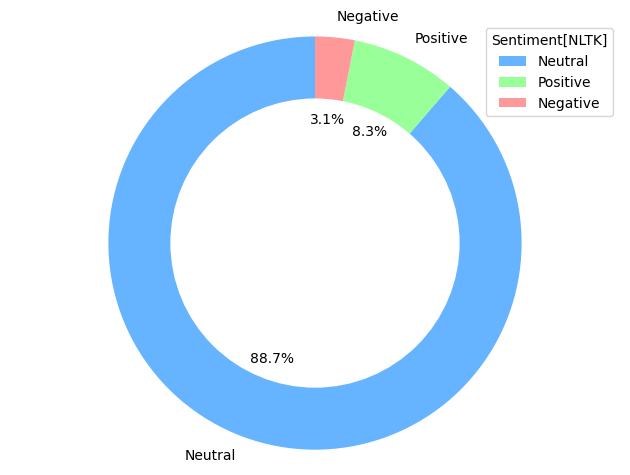

In [97]:
labels = tp.index
sizes = tp['Percentage']
colors = ['#66b3ff','#99ff99','#ff9999']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.legend(title='Sentiment[NLTK]')
plt

### Palabras más utilizadas en general (Netral,Positivo,Negativo)

<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

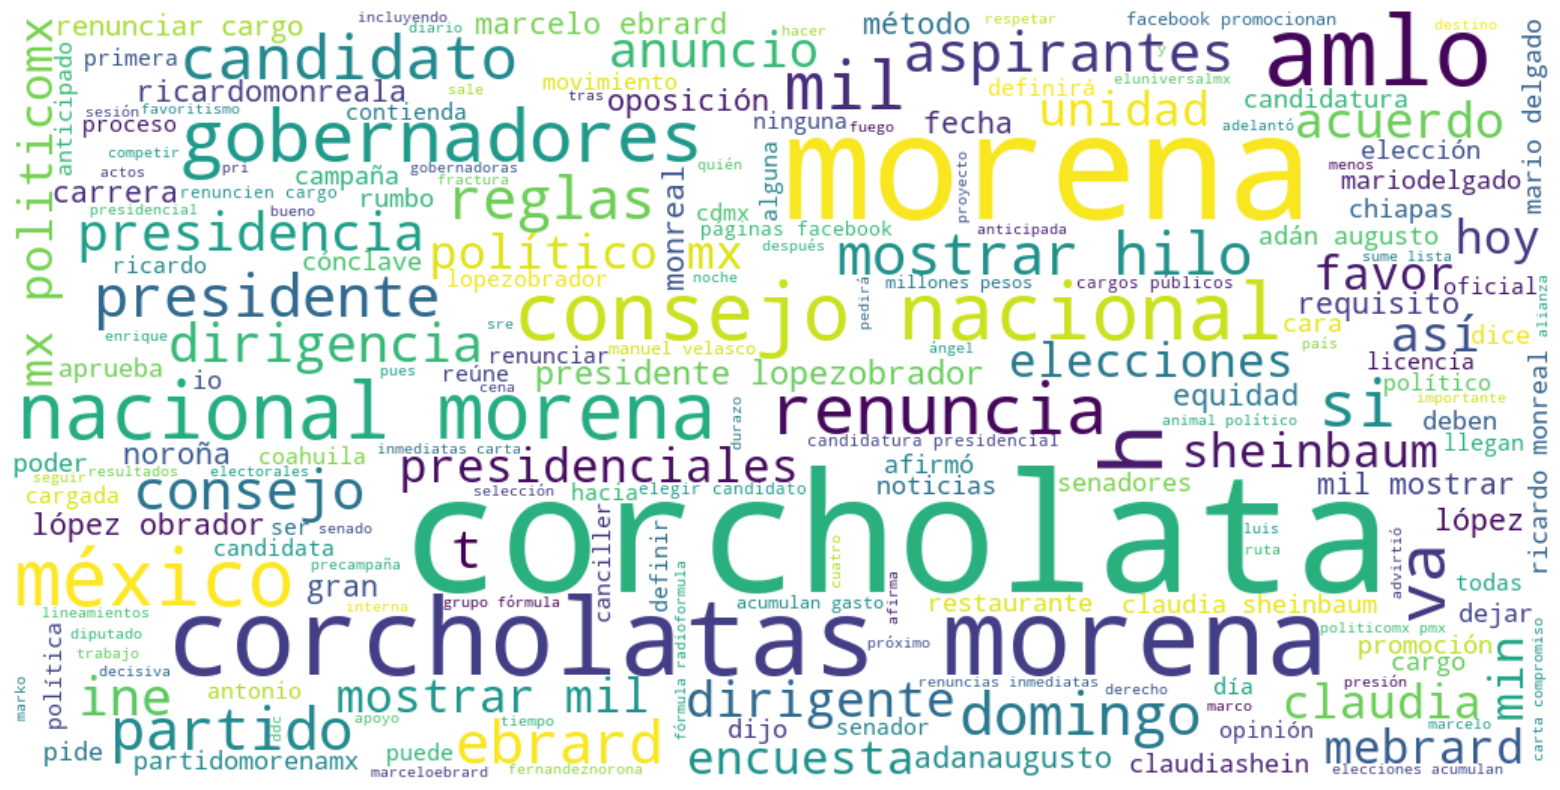

In [98]:
all_tweets = " ".join(tweet for tweet in df['tweet'])

wordcloud = WordCloud(width=1024, height=512, random_state=21, max_font_size=110, background_color='white').generate(all_tweets)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt

### Los tuits con solo sentimientos positivos



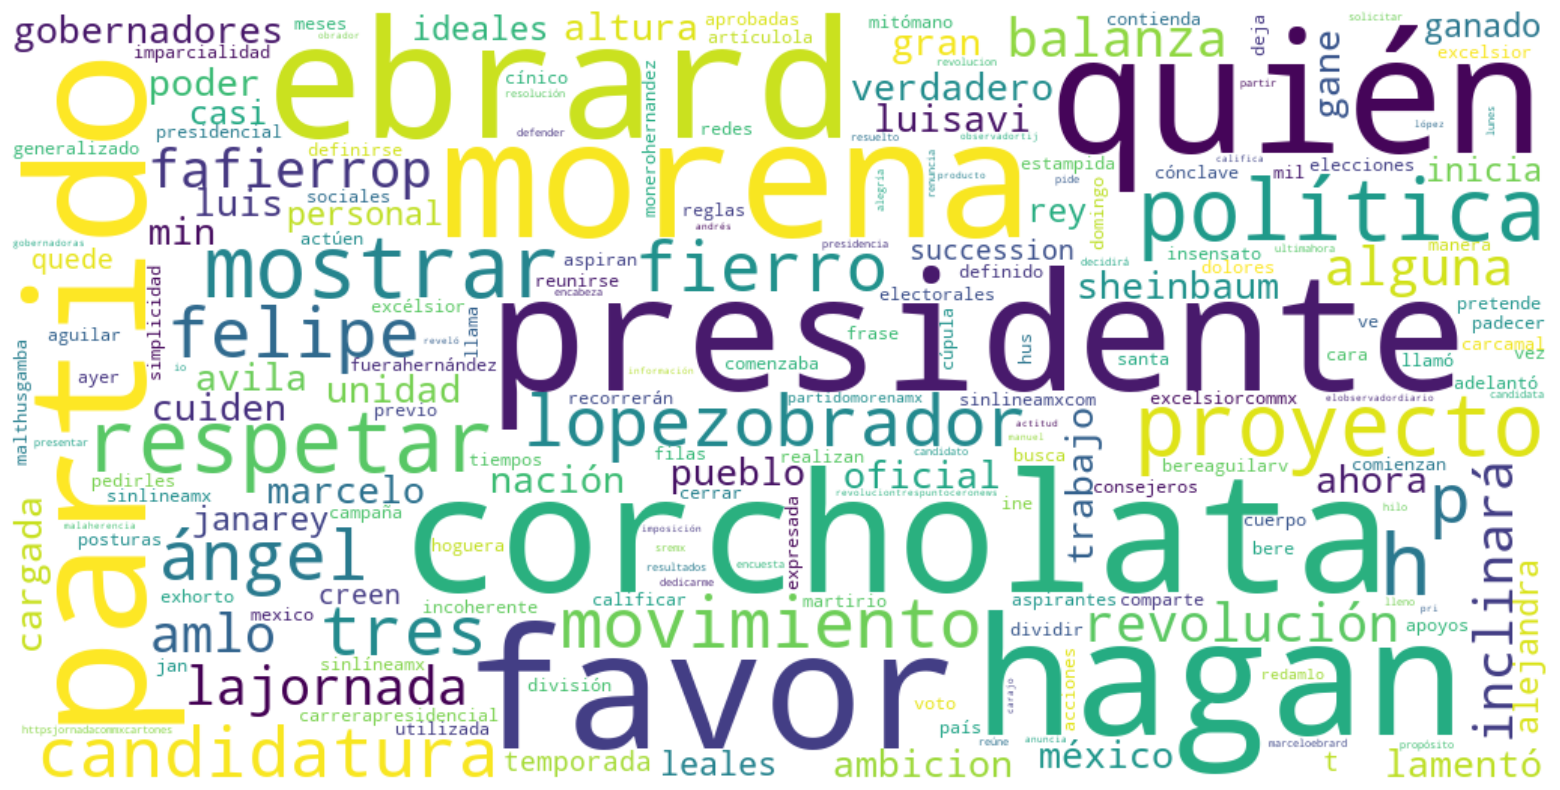

In [99]:
all_positive_tweets = " ".join(tweet for tweet in df[df['Sentiment[NLTK]'] == 'Positive']['tweet'])

wordcloud = WordCloud(width=1024, height=512, random_state=21, max_font_size=110, background_color='white', relative_scaling=0).generate(all_positive_tweets)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### y esos tweets con sentimientos negativos.

<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

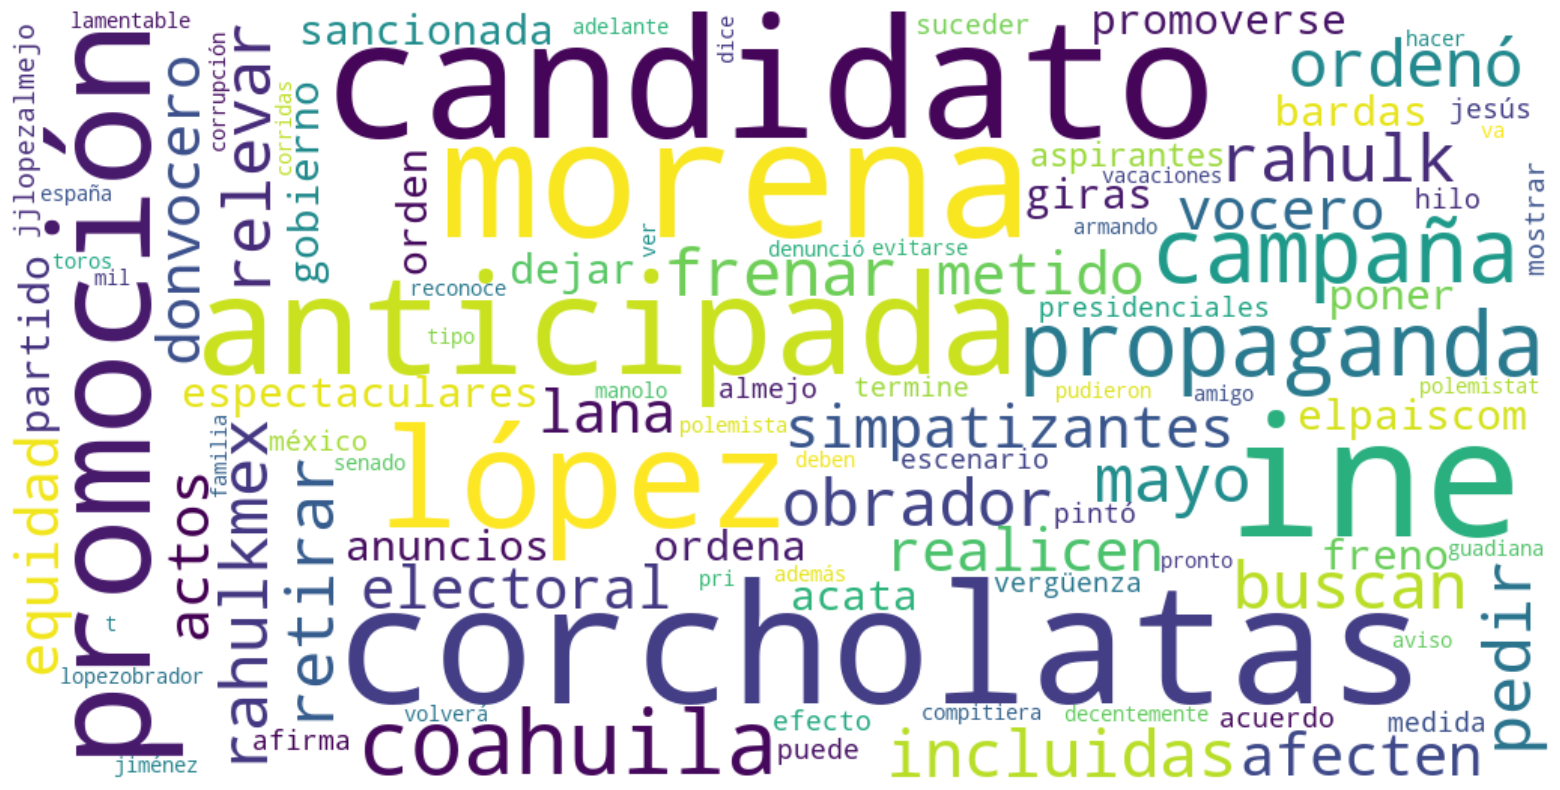

In [100]:
all_negative_tweets = " ".join(tweet for tweet in df[df['Sentiment[NLTK]'] == 'Negative']['tweet'])

wordcloud = WordCloud(width=1024, height=512, random_state=21, max_font_size=110, background_color='white').generate(all_negative_tweets)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt

In [101]:
df.head(3)

,tweet,Sentiment[NLTK]
0,joaquín lópezdóriga lopezdoriga · iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutral
1,animal político pajaropolitico · ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutral
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutral


Análisis de sentimientos utilizando un modelo pre-entrenado llamado "finiteautomata/beto-sentiment-analysis" en el framework Transformers de Hugging Face.

In [102]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

# Cargar el modelo y el tokenizador
model_name = "finiteautomata/beto-sentiment-analysis"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Definir una función para realizar el análisis de sentimientos
def analyze_sentiment(text):
    # Tokenizar el texto de entrada
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    # Obtener las predicciones de sentimiento (etiquetas y probabilidades)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).detach().numpy()[0]
    sentiment_labels = ['Negativo', 'Neutro', 'Positivo']
    predicted_label = np.argmax(probabilities)
    predicted_sentiment = sentiment_labels[predicted_label]
    predicted_probability = probabilities[predicted_label]

    # Devolver los resultados del análisis
    results = {
        'Texto': text,
        'Sentimiento': predicted_sentiment,
        'Probabilidad': predicted_probability
    }
    return results

analyze_sentiment()  toma un texto como entrada y devuelve los resultados del análisis de sentimientos. Dentro de la función, se tokeniza el texto utilizando el tokenizador, se obtienen las predicciones de sentimiento del modelo y se calculan las probabilidades correspondientes. Luego, se determina la etiqueta de sentimiento con mayor probabilidad y se asigna el sentimiento y la probabilidad correspondientes. Por último, se devuelve un diccionario con los resultados del análisis.

Guardamos en un dataset llamado df_BETO los resultados de analisis de df ( dataframe principal)

In [103]:
df_BETO = []
for x in df['tweet']:
  print(analyze_sentiment(x))
  tabla = {
      'Tweet': analyze_sentiment(x)['Texto'],
      'Sentiment': analyze_sentiment(x)['Sentimiento'],
  }
  #el resultado agregarlo como otra columna en el dataframe df
  df_BETO.append(tabla)
  

{'Texto': 'joaquín lópezdóriga lopezdoriga ·  iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil', 'Sentimiento': 'Neutro', 'Probabilidad': 0.9977307}
{'Texto': 'animal político pajaropolitico ·  ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil', 'Sentimiento': 'Neutro', 'Probabilidad': 0.95542186}
{'Texto': 'pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo', 'Sentimiento': 'Neutro', 'Probabilidad': 0.99717283}
{'Texto': 'animal político pajaropolitico ·  hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocio

In [104]:
dataframe = pd.DataFrame(df_BETO)

In [105]:
# Crear una nueva columna en un DataFrame con los nuevos datos
df_nueva_columna = pd.DataFrame({'Sentiment[BETO]': dataframe['Sentiment']})

# Concatenar el DataFrame original y el DataFrame con la nueva columna
df = pd.concat([df, df_nueva_columna], axis=1)

In [106]:
df.head(3)

,tweet,Sentiment[NLTK],Sentiment[BETO]
0,joaquín lópezdóriga lopezdoriga · iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutral,Neutro
1,animal político pajaropolitico · ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutral,Neutro
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutral,Neutro


Visualizamos con este dataframe los resultados

<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

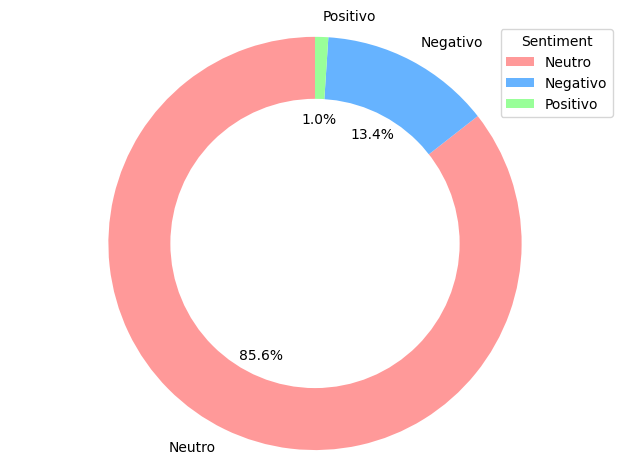

In [107]:
tp = count_tp_in_column(dataframe,'Sentiment')
tp

labels = tp.index
sizes = tp['Percentage']
colors = ['#ff9999','#66b3ff','#99ff99']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.legend(title='Sentiment')
plt

In [108]:
dataframe.head(3)

,Tweet,Sentiment
0,joaquín lópezdóriga lopezdoriga · iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutro
1,animal político pajaropolitico · ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutro
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutro


Esta seccion esta minimizada porque es algo larga, son tuits generados a mano para crear un dataset externo de entrenamiento perfectamente validado

In [109]:
tuits_para_entrenar = [
    {
        'texto': 'Corcholatas de Morena siguen arriba en ranking presidencial; Noroña salta al cuarto lugar',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'La pelea dentro de morena por la candidatura a la presidencia en 2024 ya comenzó',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Buena idea organizarse para que no se repita la historia de Morena en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Morena se desmorona y se desangra por la corrupción y la ambición de poder',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Morena mantiene ventaja en preferencias electorales rumbo a 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'A Morena le urge un cambio de dirigencia',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Andrés Manuel López Obrador, presidente de México, aseguró que Morena no se va a dividir',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Este es el momento de Morena para demostrar que es un partido diferente',
        'sentimiento': 'Positivo'
    },
    {'texto': 'Este fin de semana se determinara el futuro de Morena',
        'sentimiento': 'Neutro'
     },
    {
        'texto': 'Ninguno de los aspirantes a la presidencia de Morena tiene el perfil para gobernar',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'El canciller Marcelo Ebrard aseguró que no se va a separar de su cargo para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Marcelo Ebrard , renuncio a su cargo como canciller para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Sheinbaum, Ebrard y Delgado, los favoritos para la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Mario delgado, renuncio a su cargo como diputado para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Pelea por la candidatura de Morena a la presidencia en 2024, se calienta',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Que chingue a su madre Morena',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Mexico unido por Morena',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Noroña se registra como precandidato de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Corcholatas de Morena siguen arriba en ranking presidencial; Noroña salta al cuarto lugar',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'La pelea dentro de morena por la candidatura a la presidencia en 2024 ya comenzó',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Buena idea organizarse para que no se repita la historia de Morena en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Morena se desmorona y se desangra por la corrupción y la ambición de poder',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Morena mantiene ventaja en preferencias electorales rumbo a 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'A Morena le urge un cambio de dirigencia',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Andrés Manuel López Obrador, presidente de México, aseguró que Morena no se va a dividir',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Este es el momento de Morena para demostrar que es un partido diferente',
        'sentimiento': 'Positivo'
    },
    {'texto': 'Este fin de semana se determinara el futuro de Morena',
        'sentimiento': 'Neutro'
     },
    {
        'texto': 'Ninguno de los aspirantes a la presidencia de Morena tiene el perfil para gobernar',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'El canciller Marcelo Ebrard aseguró que no se va a separar de su cargo para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Marcelo Ebrard , renuncio a su cargo como canciller para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Sheinbaum, Ebrard y Delgado, los favoritos para la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Mario delgado, renuncio a su cargo como diputado para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Pelea por la candidatura de Morena a la presidencia en 2024, se calienta',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Que chingue a su madre Morena',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Mexico unido por Morena',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Noroña se registra como precandidato de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {'texto': 'El proceso de selección del candidato de Morena será crucial para el futuro del partido',
        'sentimiento': 'Neutro'},
    {'texto': 'Espero que los precandidatos de Morena presenten planes sólidos para abordar los problemas de seguridad en el país', 'sentimiento': 'Positivo'},
    {'texto': 'Noroña ha sido una figura controvertida, su posible candidatura podría generar división dentro de Morena',
        'sentimiento': 'Negativo'},
    {'texto': 'Morena necesita un candidato que pueda generar confianza y unidad en el partido',
        'sentimiento': 'Positivo'},
    {'texto': 'Esperemos que los precandidatos de Morena se enfoquen en propuestas realistas y viables para el desarrollo económico', 'sentimiento': 'Positivo'},
    {'texto': 'La contienda interna de Morena refleja la diversidad de ideas y opiniones dentro del partido',
        'sentimiento': 'Neutro'},
    {'texto': 'Ebrard ha demostrado habilidades diplomáticas, eso podría ser valioso para las relaciones internacionales de México', 'sentimiento': 'Positivo'},
    {'texto': 'Delgado ha trabajado en la promoción de la agenda legislativa de Morena, eso podría respaldar su candidatura', 'sentimiento': 'Positivo'},
    {'texto': 'Es importante que Morena elija a un candidato capaz de impulsar políticas públicas efectivas',
        'sentimiento': 'Positivo'},
    {'texto': 'No veo a ninguno de los precandidatos de Morena como una opción sólida y convincente para la presidencia',
        'sentimiento': 'Negativo'},
    {'texto': 'Sheinbaum ha sido una líder destacada en la Ciudad de México, eso podría fortalecer su candidatura en Morena', 'sentimiento': 'Positivo'},
    {'texto': 'Noroña ha sido una voz crítica dentro de Morena, su candidatura podría atraer a los seguidores de posturas más radicales', 'sentimiento': 'Positivo'},
    {'texto': 'Espero que los precandidatos de Morena tengan una visión clara para abordar los desafíos del cambio climático', 'sentimiento': 'Positivo'},
    {'texto': 'La unidad y cohesión interna de Morena serán fundamentales para el éxito en las próximas elecciones',
        'sentimiento': 'Positivo'},
    {'texto': 'No encuentro a ninguno de los precandidatos de Morena como un líder carismático y capaz de movilizar a las masas', 'sentimiento': 'Negativo'},
    {'texto': 'Sheinbaum ha implementado políticas públicas innovadoras en la Ciudad de México, eso podría impulsar su candidatura a nivel nacional', 'sentimiento': 'Positivo'},
    {'texto': 'Esperemos que la contienda interna de Morena se lleve a cabo de manera justa y transparente',
        'sentimiento': 'Positivo'},
    {'texto': 'Algunos precandidatos de Morena han sido señalados por presuntos actos de corrupción, eso podría afectar su imagen', 'sentimiento': 'Negativo'},
    {'texto': 'Morena necesita un candidato que pueda promover la inclusión social y combatir la desigualdad en el país',
        'sentimiento': 'Positivo'},
    {'texto': 'Espero que los precandidatos de Morena presenten soluciones efectivas para mejorar el sistema de salud en México', 'sentimiento': 'Positivo'},
    {'texto': 'El liderasgo de Sheinbaum en la Ciudad de México la posiciona como una fuerte contendiente para la candidatura presidensial de Morena.', 'sentimiento': 'Positivo'},
{'texto': 'La polarisación interna en Morena refleja la diversidad de opiniones y enfoques dentro del partído.', 'sentimiento': 'Neutro'},
{'texto': 'Noroha ha generado contoversia en el pasado, lo cual podría afectar su viavilidad como candidato de Morena.', 'sentimiento': 'Negativo'},
{'texto': 'Espero que los precandidatos de Morena presenten propuestas sólidas y realístas para impulsar el desarrollo económico del país.', 'sentimiento': 'Positivo'},
{'texto': 'La contienda interna en Morena será crucíal para definir el rumbo del partido y sus posibilidades en las elecciones.', 'sentimiento': 'Neutro'},
{'texto': 'Ebrard ha demostrado habilidades diplomáticas y esperiencia en asuntos internacionales, lo cual podría fortalecer su candidatura.', 'sentimiento': 'Positivo'},
{'texto': 'Delgado ha trabajado en el fortalecimiento de la estructura partidária de Morena, lo cual podría beneficiar su aspíración presidensial.', 'sentimiento': 'Positivo'},
{'texto': 'Espero que Morena selecsione a un candidato con visión de largo plazo y compromiso con el bienestar de la población.', 'sentimiento': 'Positivo'},
{'texto': 'La elección del candidato de Morena definirá el futuro del partido y su capacidad para mantener el apoyo popular.', 'sentimiento': 'Neutro'},
{'texto': 'No veo a ninguno de los precandidatos de Morena como líderes carismáticos capases de unir al país.', 'sentimiento': 'Negativo'},
{'texto': 'Sheinbaum ha logrado avanses significativos en materia de movilidad y medio ambíente en la Ciudad de México.', 'sentimiento': 'Positivo'},
{'texto': 'Noroha ha sido una figúra polémica, lo cual podría afectar su imagen y apoyo dentro y fuera de Morena.', 'sentimiento': 'Negativo'},
{'texto': 'Espero que los precandidatos de Morena presenten planes claros para abordar los desafíos de seguridád y justícia en el país.', 'sentimiento': 'Positivo'},
{'texto': 'La unidad interna de Morena será clave para enfrentar los retos electorales y mantener el apollo ciudadano.', 'sentimiento': 'Positivo'},
{'texto': 'No encuentro a ninguno de los precandidatos de Morena como opciones convincentes y sálidas para el país.', 'sentimiento': 'Negativo'},



]


In [110]:
df_tuits_para_entrenar = pd.DataFrame(tuits_para_entrenar)

Mostramos el dataset

In [111]:
df_tuits_para_entrenar

,texto,sentimiento
0,Corcholatas de Morena siguen arriba en ranking presidencial; Noroña salta al cuarto lugar,Positivo
1,La pelea dentro de morena por la candidatura a la presidencia en 2024 ya comenzó,Negativo
2,Buena idea organizarse para que no se repita la historia de Morena en 2024,Positivo
3,Morena se desmorona y se desangra por la corrupción y la ambición de poder,Negativo
4,Morena mantiene ventaja en preferencias electorales rumbo a 2024,Positivo
...,...,...
66,Sheinbaum ha logrado avanses significativos en materia de movilidad y medio ambíente en la Ciudad de México.,Positivo
67,"Noroha ha sido una figúra polémica, lo cual podría afectar su imagen y apoyo dentro y fuera de Morena.",Negativo
68,Espero que los precandidatos de Morena presenten planes claros para abordar los desafíos de seguridád y justícia en el país.,Positivo
69,La unidad interna de Morena será clave para enfrentar los retos electorales y mantener el apollo ciudadano.,Positivo


Procesamos los tuits que creamos

In [112]:
# Aplicar preprocesamiento a la columna 'texto'
df_tuits_para_entrenar['texto'] = df_tuits_para_entrenar['texto'].apply(preprocess_text)

# Imprimir el DataFrame con el texto preprocesado
df_tuits_para_entrenar.head(3)

,texto,sentimiento
0,corcholatas morena siguen arriba ranking presidencial noroña salta cuarto lugar,Positivo
1,pelea dentro morena candidatura presidencia comenzó,Negativo
2,buena idea organizarse repita historia morena,Positivo


### Con nuestro dataset propio vamos a crear un modelo con Naive Bayes con libreria y lo probaremos con los tuits que generamos scrapping

In [113]:
#!pip install accelerate -U

In [114]:
dataset = df_tuits_para_entrenar

In [115]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import joblib
import nltk
from nltk.tokenize import word_tokenize

# Esta es nuestra función de análisis que será utilizada en lugar de la función lambda
def tokenize(text):
    return text

# nltk.download('punkt')

dataset['texto_tokenizado'] = dataset['texto'].apply(word_tokenize)

# Pasamos nuestra nueva función de análisis a CountVectorizer
vectorizer = CountVectorizer(analyzer=tokenize)
X = vectorizer.fit_transform(dataset['texto_tokenizado'].tolist())

y = dataset['sentimiento'].map({'Negativo': 0, 'Positivo': 1, 'Neutro': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

joblib.dump(model, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

model = joblib.load('model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

def predict_sentiment(text):
    tokens = word_tokenize(text)
    features = vectorizer.transform([tokens])
    sentiment = model.predict(features)[0]
    return {0: 'Negativo', 1: 'Positivo', 2: 'Neutro'}[sentiment]


In [116]:
predicciones = []
for x in df['tweet']:
    tabla = {
        'Tweet': predict_sentiment(x),
    }
    predicciones.append(tabla)


apilamos predicciones en df con el nombre de Model_Sentiment

In [117]:
df['Sentiment[Naive Bayes]'] = predicciones
df.head(3)

,tweet,Sentiment[NLTK],Sentiment[BETO],Sentiment[Naive Bayes]
0,joaquín lópezdóriga lopezdoriga · iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutral,Neutro,{'Tweet': 'Neutro'}
1,animal político pajaropolitico · ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutral,Neutro,{'Tweet': 'Neutro'}
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutral,Neutro,{'Tweet': 'Neutro'}


Cambiamos los datos categoricos por numericos

In [118]:
for x in df['Sentiment[NLTK]']:
    if x == "Neutral":
        #reemplazar por 1 
        df['Sentiment[NLTK]'] = df['Sentiment[NLTK]'].replace(x, 2)
    elif x == "Negative":
        #reemplazar por 2
        df['Sentiment[NLTK]'] = df['Sentiment[NLTK]'].replace(x, 0)
    elif x == "Positive":
            #reemplazar por 0
            df['Sentiment[NLTK]'] = df['Sentiment[NLTK]'].replace(x, 1)

In [119]:
for x in df['Sentiment[BETO]']:
    if x == "Neutro":
        #reemplazar por 1 
        df['Sentiment[BETO]'] = df['Sentiment[BETO]'].replace(x, 2)
    elif x == "Positivo":
        #reemplazar por 2
        df['Sentiment[BETO]'] = df['Sentiment[BETO]'].replace(x, 0)
    elif x == "Negativo":
            #reemplazar por 0
            df['Sentiment[BETO]'] = df['Sentiment[BETO]'].replace(x, 1)

In [120]:
def convert_sentiment(sentiment):
    if sentiment['Tweet'] == 'Positivo':
        return 0
    elif sentiment['Tweet'] == 'Negativo':
        return 1
    elif sentiment['Tweet'] == 'Neutro':
        return 2


df['Sentiment[Naive Bayes]'] = df['Sentiment[Naive Bayes]'].apply(convert_sentiment)


In [121]:
df

,tweet,Sentiment[NLTK],Sentiment[BETO],Sentiment[Naive Bayes]
0,joaquín lópezdóriga lopezdoriga · iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,2,2,2
1,animal político pajaropolitico · ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2,2
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,2,2,2
3,animal político pajaropolitico · hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2,2
4,stephany lavalle steplavalle · amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal,2,2,0
...,...,...,...,...
92,central equilibrio centraleq · new podcast primera emisión io on spreaker t adrianabraniff aliados centralfm centrallive colmex corcholatas diputados elecciones guadalupeacosta morena oposicion pedroferriz presidencia primarias reynaldoortega spreakercom primera emisión io xóchitl gálvez senadora pan comenta resolución juez otorga derecho réplica mañanera guadalupe acosta naranjo habla pautas seguir sociedad,2,2,2
93,fuego lento noticias afuegolentonews · opinión ruta ebrard fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos información afuegolentonoticiascom ruta ebrad fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos,2,1,0
94,jesús lópez almejo jjlopezalmejo · vergüenza candidato coahuila pintó escenario puede suceder morena méxico termine efecto lopezobrador tipo candidatos corcholatas pudieron hacer compitiera decentemente deben evitarse adelante aviso polemista t polemistat · lamentable armando guadiana reconoce denunció campaña corrupción manolo jiménez pri amigo familia además dice volverá pronto senado va vacaciones españa ver corridas toros coahuila mil,0,2,0
95,vivo noticias vivonoticiasmx · h acuerdo corcholatas adelanta sheinbaum domingo realizará consejo político nacional morena presentes aspirantes presidencia méxico httpsvivonoticiasmxnotasnotaphpidn…,2,2,0


Esta parte quiza fue la más engorrosa del programa y fue catalogar a mano los tuits y compararlos con la columna Sentiment que fue utilizando una funcion BETO  o la tabla Model_Sentiment con nuestro modelo bayes y nuestro dataset de entrenamiento

In [122]:
# Crear una nueva columna "datos_reales" inicializada con valores nulos
df['datos_reales'] = None

# Iterar sobre el dataframe

# DESCOMENTAR ESTA SECCION


#for index, row in df.iterrows():
#    tweet = row['Tweet']
#    # Solicitar entrada al usuario
#    num = int(input("Introduce un número entero (0-2) para el tweet '{}': ".format(tweet)))
    
#    # Verificar si el número está en el rango correcto
#    while num < 0 or num > 2:
#        print("Número inválido. Inténtalo de nuevo.")
#        num = int(input("Introduce un número entero (0-2) para el tweet '{}': ".format(tweet)))
    
#    # Asignar el número ingresado a la columna "datos_reales"
#    df.loc[index, 'datos_reales'] = num


In [123]:
#guardar en csv el dataframe

#DESCOMENTAR

#dataframe.to_csv('Primera_Comparacion.csv')

In [124]:
#leer el csv llamado Primera_Comparacion.csv y pasarlo a un dataframe llamado df_comparacion
df_comparacion = pd.read_csv('Primera_Comparacion.csv')

In [125]:
df_comparacion.head(10)

,Unnamed: 0,Tweet,Sentiment,Model_Sentiment,datos_reales
0,0,joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,2,2,2
1,1,animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2,1
2,2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,2,2,2
3,3,animal político pajaropolitico · jun hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2,1
4,4,stephany lavalle steplavalle · jun amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal,2,0,2
5,5,catrina norteña catrinanortena · jun lamalolienteerestúdresser ultimátum mebrard amlo reúne cenar gobernadores morena corcholatas debido ebrard quiere respetar reglas establecidas elegir candidatao presidencial t claudiashein marcelo… mostrar mil,2,0,2
6,6,vianey vianeicita · min entiendo gobernador durazo pdte consejo morena digo últimas semanas ocupado grilla corcholatas q gobernantes deberían dedicarse exclusivamente pueblo q eligió,1,0,1
7,7,ddc ddconfianza · jun ultimahora filtra video mayito delgado revelando método selección candidat presidencial morena ¡y corcholatas soportan bueno sí… míralo compártelo,2,2,1
8,8,bere aguilar bereaguilarv · h llegó día definiciones cuatro corcholatas presidenciales consejo nacional morena si bien abordarán varios temas relevantes renuncias actuales cargos falta ver si hoy mismo resolverá asunto crucial cómo encuesta para… mostrar,2,0,2
9,9,laura brugés laurabruges · jun movimiento corcholatas morena anexos va generar cascada movimientos enroques importantes gabinete amlo gubernaturas poder legislativo vamo ve… mil mostrar hilo,2,1,1


In [126]:
#extraer los valores de datos_reales y agregarlos a df como una nueva columna llamada datos_reales
df['datos_reales'] = df_comparacion['datos_reales']

In [127]:
df.head(10)

,tweet,Sentiment[NLTK],Sentiment[BETO],Sentiment[Naive Bayes],datos_reales
0,joaquín lópezdóriga lopezdoriga · iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,2,2,2,2
1,animal político pajaropolitico · ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2,2,1
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,2,2,2,2
3,animal político pajaropolitico · hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2,2,1
4,stephany lavalle steplavalle · amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal,2,2,0,2
5,catrina norteña catrinanortena · lamalolienteerestúdresser ultimátum mebrard amlo reúne cenar gobernadores morena corcholatas debido ebrard quiere respetar reglas establecidas elegir candidatao presidencial t claudiashein marcelo… mostrar mil,2,2,0,2
6,vianey vianeicita · min entiendo gobernador durazo pdte consejo morena digo últimas semanas ocupado grilla corcholatas q gobernantes deberían dedicarse exclusivamente pueblo q eligió,2,1,0,1
7,ddc ddconfianza · ultimahora filtra video mayito delgado revelando método selección candidat presidencial morena ¡y corcholatas soportan bueno sí… míralo compártelo,2,2,2,1
8,bere aguilar bereaguilarv · h llegó día definiciones cuatro corcholatas presidenciales consejo nacional morena si bien abordarán varios temas relevantes renuncias actuales cargos falta ver si hoy mismo resolverá asunto crucial cómo encuesta para… mostrar,2,2,0,2
9,laura brugés laurabruges · movimiento corcholatas morena anexos va generar cascada movimientos enroques importantes gabinete amlo gubernaturas poder legislativo vamo ve… mil mostrar hilo,2,2,1,1


Calcular la puntuación para cada fila

In [128]:
puntosNLTK = 0
puntosBeto = 0
puntosBayes = 0

for index, row in df.iterrows():
    punto = 0

    if row['Sentiment[NLTK]'] == row['datos_reales']:
        puntosNLTK += 1

    if row['Sentiment[BETO]'] == row['datos_reales']:
        puntosBeto += 1
    if row['Sentiment[Naive Bayes]'] == row['datos_reales']:
        puntosBayes += 1


print("Puntos del modelo de NLTK: {}".format(puntosNLTK))
print("Puntos del modelo usando Bayes: {}".format(puntosBayes))
print("Puntos del modelo usando BETO: {}".format(puntosBeto))

# Calcular la precisión
precicionNLTK = puntosNLTK / len(df_comparacion)
preciosionBayes = puntosBayes / len(dataframe)
precision_BETO = puntosBeto / len(df_comparacion)

print("Precisión del modelo de NLTK: {}".format(precicionNLTK))
print("Precisión del modelo usando Bayes: {}".format(preciosionBayes))
print("Precisión del modelo usando BETO: {}".format(precision_BETO))

Puntos del modelo de NLTK: 63
Puntos del modelo usando Bayes: 27
Puntos del modelo usando BETO: 74
Precisión del modelo de NLTK: 0.6494845360824743
Precisión del modelo usando Bayes: 0.27835051546391754
Precisión del modelo usando BETO: 0.7628865979381443


In [129]:
PruebaUsuario = "Morena va y chinga a su madre"

predict_sentiment(PruebaUsuario)

'Positivo'

In [130]:
model_name = "finiteautomata/beto-sentiment-analysis"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

analyze_sentiment (PruebaUsuario)

{'Texto': 'Morena va y chinga a su madre',
 'Sentimiento': 'Negativo',
 'Probabilidad': 0.98446506}

Nuestro modelo de Bayes no fue el mejor, nuestro modelo de NLTK mejoro pero el modelo de BETO es buenisimo

- Puntos del modelo de NLTK: 63
- Puntos del modelo usando Bayes: 27
- Puntos del modelo usando BETO: 74
- Precisión del modelo de NLTK: 0.6494845360824743
- Precisión del modelo usando Bayes: 0.27835051546391754
- Precisión del modelo usando BETO: 0.7628865979381443